## CE-like background: third pass

Use processor template on full dataset 

Dataset: `nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root`

First file: `nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00050440.root`

File lists: `/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.*.txt`

## Imports

A bit awkard but I'm using my dev version of pyutils 

In [1]:
!ls ../../../EventNtuple/utils/pyutils

_env_manager.py  pylogger.py  pyprint.py    pyselect.py    README.md
mu2e.mplstyle	 pymcutil.py  pyprocess.py  pyutils_tests
pyimport.py	 pyplot.py    pyread.py     pyvector.py


In [3]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import hist
import gc
import sys

sys.path.append("../../../EventNtuple/utils/pyutils")
from pyprocess import Processor, Skeleton
from pyplot import Plot
from pyprint import Print
from pyselect import Select
from pyvector import Vector

sys.path.append("../common")
from cut_manager import CutManager
from analyse import Analyse

# Create Processor 

In [8]:
# Create your custom processor class
# We inherit from Skeleton - this gives us many pre-built methods without writing extra code
class CosmicProcessor(Skeleton):
    """Your custom file processor 
    
    This class inherits from the Skeleton base class, which provides the 
    basic structure and methods withing the Processor framework 
    """
    def __init__(self):
        """Initialise your processor with specific configuration
        
        This method sets up all the parameters needed for this specific analysis.
        """
        # Call the parent class's __init__ method first
        # This ensures we have all the base functionality properly set up
        super().__init__()

        # Now override parameters from the Skeleton with the ones we need
        # Data selection configuration 
        self.defname = "nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root"
        # self.file_list_path = "//exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_24.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_99.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/EventNtuple/TestFileLists/local_file_list.txt"
    
        self.branches = { 
            "evt" : [
                "run",
                "subrun",
                "event",
            ],
            "crv" : [
                "crvcoincs.time",
                "crvcoincs.nHits"
            ],
            "trk" : [
                "trk.nactive", 
                "trk.pdg", 
                "trkqual.valid",
                "trkqual.result"
            ],
            "trkfit" : [
                "trksegs",
                "trksegpars_lh"
            ],
            "trkmc" : [
                "trkmcsim"
            ]
        }
        self.use_remote = True     # Use remote file via mdh
        self.location = "disk"     # File location
        self.max_workers = 50      # Limit the number of workers
        self.verbosity = 2         # Set verbosity 
        self.use_processes = True  # Use processes rather than threads
        
        # Now add your own analysis-specific parameters 

        # Init analysis methods
        # Would be good to load an analysis config here 
        self.analyse = Analyse(verbosity=0)
            
        # Custom prefix for log messages from this processor
        self.print_prefix = "[CosmicProcessor] "
        print(f"{self.print_prefix}Initialised")
    
    # ==========================================
    # Define the core processing logic
    # ==========================================
    # This method overrides the parent class's process_file method
    # It will be called automatically for each file by the execute method
    def process_file(self, file_name): 
        """Process a single ROOT file
        
        This method will be called for each file in our list.
        It extracts data, processes it, and returns a result.
        
        Args:
            file_name: Path to the ROOT file to process
            
        Returns:
            A tuple containing the histogram (counts and bin edges)
        """
        try:
            # Create a local pyprocess Processor to extract data from this file
            # This uses the configuration parameters from our class
            this_processor = Processor(
                use_remote=self.use_remote,     # Use remote file via mdh
                location=self.location,         # File location
                verbosity=0 # self.verbosity        # Reduce output in worker threads
            )
            
            # Extract the data 
            this_data = this_processor.process_data(
                file_name = file_name, 
                branches = self.branches
            )
            
            # ---- Analysis ----            
            results = self.analyse.execute(this_data, file_name)

            # Clean up
            gc.collect()

            return results 
        
        except Exception as e:
            # Handle any errors that occur during processing
            print(f"{self.print_prefix}Error processing {file_name}: {e}")
            return None

    ## Need postprocessing and failure handling!    

In [6]:
# test_processor = Processor(
#     use_remote=True,     # Use remote file via mdh
#     location="disk",         # File location
#     verbosity=2 # self.verbosity        # Reduce output in worker threads
# )
# test_list = test_processor.get_file_list(
#     defname="nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root"
#     # file_list_path="/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_24.txt"
# )

In [7]:
# print(test_list)

In [9]:
# ==========================================
# Create and run the processor
# ==========================================
# Create an instance of our custom processor
cosmic_processor = CosmicProcessor()

# Run the processor on all files
# The execute method comes from the Skeleton parent class
# This starts a parent Processor and submits the process function to the threads

# import tracemalloc
# import os
# import psutil

# # Start memory tracking
# tracemalloc.start()

# # Take a baseline snapshot
# print("Starting memory tracking")
# baseline = tracemalloc.take_snapshot()

# # Print initial memory usage
# process = psutil.Process(os.getpid())
# memory_before = process.memory_info().rss / (1024 * 1024)
# print(f"Initial memory usage: {memory_before:.2f} MB")

# Execute your processor
results = cosmic_processor.execute()

# # Take final snapshot and measure memory increase
# snapshot = tracemalloc.take_snapshot()
# memory_after = process.memory_info().rss / (1024 * 1024)
# memory_diff = memory_after - memory_before

# # Compare snapshots and show top differences
# print(f"\nTOP 10 MEMORY DIFFERENCES:")
# top_stats = snapshot.compare_to(baseline, 'lineno')
# for stat in top_stats[:10]:
#     print(stat)

# # Print overall memory change
# print(f"\nTotal memory change: {memory_diff:.2f} MB ({memory_before:.2f} MB → {memory_after:.2f} MB)")

# You can now analyse the results

[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] Initialised
[Skeleton] ⭐️ Starting analysis
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=2
[pyprocess] 👀 Loading file list for SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
[pyprocess] ✅ Successfully loaded file list
	SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
	Count: 817 files
[pyprocess] ⭐️ Starting processing on 817 files with 50 processes


Processing: 100%|██████████████████████████████| 817/817 [04:27<00:00,  3.06file/s, successful=817, failed=0]

[pyprocess] ⭐️ Returning 817 results
[Skeleton] ✅ Analysis complete


In [10]:
# Helper to convert the cut stats into a list 
def get_stats_list(results):
    # One line solution
    #  return [result["cut_stats"] for result in results if "cut_stats" in result]
    # Readable solution 
    stats = [] 
    for result in results: 
        if "cut_stats" in result: 
            stats.append(result["cut_stats"])
    return stats

stats = get_stats_list(results)

cut_manager = CutManager()

combined_stats = cut_manager.combine_cut_stats(stats)
cut_manager.print_cut_stats(stats=combined_stats, active_only=False, csv_name="../../txt/cut_stats_ana_2.csv")


[pyselect] Cut Info:
--------------------------------------------------------------------------------------------------------------
Cut                  Active     Events Passing       Absolute Frac. [%]   Relative Frac. [%]   Description                   
--------------------------------------------------------------------------------------------------------------
No cuts              N/A        5754129              100.00               100.00               No selection applied          
is_truth_electron    1          2319356              40.31                40.31                Track parents are electrons (truth PID)
is_reco_electron     1          2136407              37.13                92.11                Tracks are assumed to be electrons (trk)
is_downstream        1          1524458              26.49                71.36                Downstream tracks only (p_z > 0 through tracker)
has_hits             1          1293380              22.48                84.84          

In [11]:
print(results[0]["histograms"])
# !cat ../txt/cut_stats_ana_2.csv

{'Wide range': Hist(
  Regular(1000, 0, 1000, name='momentum', label='Momentum [MeV/c]'),
  StrCategory(['All tracks', 'CE-like tracks'], name='selection', label='Selection'),
  storage=Double()) # Sum: 40099.0 (40107.0 with flow), 'Signal region': Hist(
  Regular(13, 103.6, 104.9, name='momentum', label='Momentum [MeV/c]'),
  StrCategory(['All tracks', 'CE-like tracks'], name='selection', label='Selection'),
  storage=Double()) # Sum: 329.0}


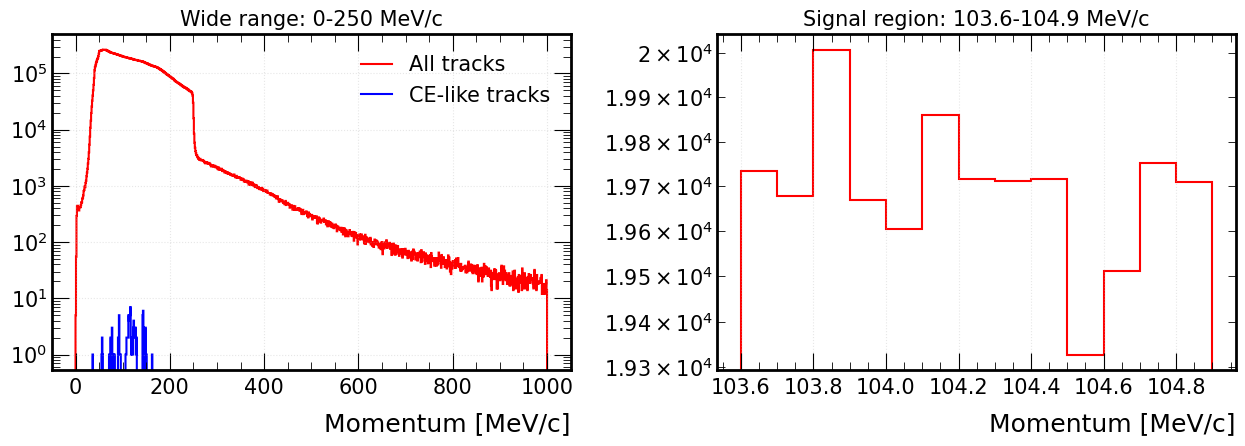

In [16]:
# Should be in postprocessing 

def combine_histograms(results):
    """Combine histograms from multiple files
    
    Args:
        file_results: Dictionary with file IDs as keys and results as values
                     Each result contains a 'histograms' dict
    
    Returns:
        dict: Combined histograms
    """
    combined_hists = {}
    
    # Check if we have results
    if not results:
        return None
    
    # Loop through all files
    for result in results: # 
        # Skip if no histograms in this file
        if 'histograms' not in result or not result['histograms']:
            continue
        
        # Process each histogram type
        for hist_name, hist_obj in result['histograms'].items():
            if hist_name not in combined_hists:
                # First time seeing this histogram type, initialise
                combined_hists[hist_name] = hist_obj.copy()
            else:
                # Add this histogram to the accumulated one
                combined_hists[hist_name] += hist_obj
    
    return combined_hists

# Combine hists 
combined_histograms = combine_histograms(results)

# Now you can plot them
plt.style.use("../../../EventNtuple/utils/pyutils/mu2e.mplstyle")
fig, axes = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

# Plot wide range in first subplot
if 'Wide range' in combined_histograms:
    h_wide = combined_histograms['Wide range']
    h_wide.plot1d(overlay='selection', ax=axes[0])
    # h_wide.sum().value
    axes[0].set_title("Wide range: 0-250 MeV/c")
    axes[0].set_yscale('log')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(frameon=False)

# Plot signal region in second subplot
if 'Signal region' in combined_histograms:
    h_signal = combined_histograms['Signal region']
    h_signal.plot1d(overlay='selection', ax=axes[1])
    axes[1].set_title("Signal region: 103.6-104.9 MeV/c")
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylabel("")  # Remove duplicate y-label
    axes[0].legend(frameon=False)


plt.tight_layout()
plt.savefig("../../img/h1_ana_2_mom.png", dpi=300)
plt.show()

## This is not right. I want to plot unvetoed CE-like tracks, but I think I'm actually plotting unvetoed tracks. Need to fix!

In [18]:
h_wide = combined_histograms['Wide range']
h_wide = h_wide[{'selection': 'CE-like tracks'}]  # Use dictionary-based slicing
n = h_wide.sum()
n

109.0

In [19]:
# Postprocessing 
def combine_arrays(results):
    """Combine arrays from multiple files
    
    """
    arrays_to_combine = []
    
    # Check if we have results
    if not results:
        return None
    
    # Loop through all files
    for result in results: # 

        array = result["filtered_data"]

        if len(array) == 0:
            continue
        
        # Concatenate arrays
        arrays_to_combine.append(array) 
    
    return ak.concatenate(arrays_to_combine)

data = combine_arrays(results)
printer = Print()

printer.print_n_events(data, n_events=len(data))

[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[pyprint] ⭐️ Printing 13 event(s)...

-------------------------------------------------------------------------------------
evt.event: 83244
evt.run: 1202
evt.subrun: 2135
crv.crvcoincs.time: [9.18e+04, 9.19e+04, 9.17e+04]
crv.crvcoincs.nHits: [18, 19, 10]
trk.trk.pdg: [11, -11, -11, 11, 13, -13, -13, 13]
trk.trk.nactive: [36, 15, 34, 16, 36, 16, 33, 14]
trk.trkqual.valid: [True, True, True, True, True, True, True, True]
trk.trkqual.result: [0.93, 0.0185, 0.0418, 0.021, 0.56, 0.016, 0.0527, 0.0147]
trkfit.trksegs.mom.fCoordinates.fX: [[86.7, -107, -112, -91.6, -100, -68.3, 6.89, -66, -73.5, 26.4], ..., [...]]
trkfit.trksegs.mom.fCoordinates.fY: [[-66.8, -37.7, -34.7, -66.7, -44.9, 71.1, -97.1, 66.8, -56.9, -88.4], ...]
trkfit.trksegs.mom.fCoordinates.fZ: [[-42.4, -29.3, 1.86, 16.7, 32, 57.5, 59.3, 64.4, 65.1, 65.6], ..., [...]]
trkfit.trksegs.pos.fCoordinates.fX: [[-76.1, 1.72, 8.67, -63.9, -22.2, 300, -191, 329, -73

In [29]:
# data

events = ak.flatten(data["evt"]["event"], axis=None)

subruns = ak.flatten(data["evt"]["subrun"], axis=None)

print("event, subrun")
for i in range(len(events)):
    print(f"{events[i]}, {subruns[i]}")

event, subrun
83244, 2135
462972, 11642
210248, 17654
283508, 17940
470964, 17999
362133, 34436
342962, 54806
61884, 53026
38729, 63475
2839, 65234
487567, 69218
460915, 71818
17653, 79922


In [8]:
print(combined_histograms)

{'Wide range': Hist(
  Regular(250, 0, 250, name='momentum', label='Momentum [MeV/c]'),
  StrCategory(['All events', 'CE-like events'], name='selection', label='Selection'),
  storage=Double()) # Sum: 32057065.0 (32456288.0 with flow), 'Signal region': Hist(
  Regular(13, 103.6, 104.9, name='momentum', label='Momentum [MeV/c]'),
  StrCategory(['All events', 'CE-like events'], name='selection', label='Selection'),
  storage=Double()) # Sum: 256003.0 (256008.0 with flow)}
